In [1]:
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
from scipy.stats import gamma, genpareto, norm
from scipy import optimize
from scipy.stats import bootstrap

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "../cpc-global/NAM_sub_precip", engine='netcdf4')  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
alias = {1:'Baja', 2:'CA-AZ', 3:'SNV', 4:'4C', 5:'AZ-NM', 6:'SON', 7:'SIN'}

/global/homes/d/duan0000/.conda/envs/duan/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


# Fit functions

In [3]:
def genpareto_objective_fn(theta, x, dis_func):
    scale = theta[-1]
    loc = 1 # starts from 1
    x = (np.asarray(x)-loc) / scale
    a = theta[0]
    args = (a, scale)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    return -np.sum(logpdf, axis=0)

def genpareto_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    logpdf = dis_func.logpdf(x, a, loc=0, scale=scale)
    finite_logpdf = np.isfinite(logpdf)
    # print(np.sum(finite_logpdf))
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def genpareto_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 1
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a<0:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return genpareto_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_genpareto_parameters(data, dis_func):
    function = genpareto_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args
def gamma_objective_fn(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = args[0]
    scale = theta[-1]
    loc = 0 # starts from 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func)

def gamma_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a, scale=1)/scale
    total_pdf = 1 - dis_func.cdf(1, a, loc=0, scale=scale) # from 1 to inf
    pdf = pdf/total_pdf
    logpdf = np.log(pdf)
    finite_logpdf = np.isfinite(logpdf)
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def gamma_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a>1:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_gamma_parameters(data, dis_func):
    function = gamma_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args


In [4]:
def fit_gamma_genpareto(data, ax, x):
    a1, scale1 = fit_gamma_parameters(data, gamma)
    pdf1 = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
    score_ga = gamma_objective_fn(x=data, theta=(a1, scale1), dis_func=gamma)
    # print('Gamma: ', score_ga)
    if ax is not None:
        ax.plot(x, pdf1, color='red')
    a2, scale2 = fit_genpareto_parameters(data, genpareto)
    pdf2 = genpareto.pdf(x, a2, 1, scale2)
    score_gp = genpareto_objective_fn(x=data, theta=(a2, scale2), dis_func=genpareto)
    # print('GenPareto: ', score_gp)
    if ax is not None:
        ax.plot(x, pdf2, color='blue', label='GenPareto')
    return (a1, scale1), (a2, scale2), np.max([pdf2, pdf1]), (score_ga, score_gp)

In [5]:
def get_precip(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
    # tc_sub = np.load(str(sub_id)+'_all_TC.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    # two-way
    tc_tutt_precip = []
    tc_mcs_precip = []
    tc_surge_precip = []
    tc_front_precip = []
    tc_midtro_precip = []
    tutt_mcs_precip = []
    tutt_surge_precip = []
    tutt_midtro_precip = []
    tutt_front_precip = []
    mcs_midtro_precip = []
    mcs_front_precip = []
    mcs_surge_precip = []
    midtro_front_precip = []
    midtro_surge_precip = []
    front_surge_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        # 2-way
        if midtro_sub[i]>0 and front_sub[i]>0:
            midtro_front_precip.append(sub_precip[i])
        if midtro_sub[i]>0 and surge_sub[i]>0:
            midtro_surge_precip.append(sub_precip[i])
        if surge_sub[i]>0 and front_sub[i]>0:
            front_surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and front_sub[i]>0:
            mcs_front_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and midtro_sub[i]>0:
            mcs_midtro_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and surge_sub[i]>0:
            mcs_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and tutt_sub[i]>0:
            tc_tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0 and front_sub[i]>0:
            tc_front_precip.append(sub_precip[i])
        if tc_sub[i]>0 and surge_sub[i]>0:
            tc_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and midtro_sub[i]>0:
            tc_midtro_precip.append(sub_precip[i])
        if tc_sub[i]>0 and mcs_sub[i]>0:
            tc_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and front_sub[i]>0:
            tutt_front_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and surge_sub[i]>0:
            tutt_surge_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and midtro_sub[i]>0:
            tutt_midtro_precip.append(sub_precip[i])
    two_way_precip = [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
                      tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
                      mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
                      midtro_front_precip, midtro_surge_precip,
                      front_surge_precip,]
    return [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
            two_way_precip

In [6]:
two_way_names = ['TC_UTT', 'TC_mcs', 'TC_surge', 'TC_front', 'TC_midtro',
                 'UTT_MCS', 'UTT_Surge', 'UTT_Midtro', 'UTT_Front',
                 'MCS_Midtro', 'MCS_Front', 'MCS_Surge',
                 'Midtro_Front', 'Midtro_Surge',
                 'Front_Surge',]
names = ['TC', 'UTT', 'Surge', 'Midtro', 'Front', 'MCS']
print(len(two_way_names)+len(names))

21


In [7]:
def CDF_single_print(sub_id, precip_list):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    print('TOTAL: ', len(sub_precip))
    x = np.logspace(1, np.log(extreme*2), num=100, base=np.e)
    for i, precip in enumerate(precip_list):
        # print(names[i], len(precip))
        if len(precip) > 3:
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            if score_ga<score_gp:
                pdf = pdf = (gamma.cdf(x, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                threshold = 1- (gamma.cdf(extreme, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                dis = 'Gamma'
                print(names[i], threshold, score_ga)
            else:
                pdf = genpareto.cdf(x, a2, 1, scale2)
                dis = 'GenPareto'
                threshold = 1 - genpareto.cdf(extreme, a2, 1, scale2)
                print(names[i], threshold, score_gp)              

In [8]:
def CDF_single(sub_id, two_way_precip, precip_list, ax):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    print('TOTAL: ', len(sub_precip))
    x = np.logspace(1, np.log(extreme*2), num=100, base=np.e)
    for i, precip in enumerate(precip_list):
        # print(names[i], len(precip))
        if len(precip) > 3:
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            if score_ga<score_gp:
                pdf = pdf = (gamma.cdf(x, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                threshold = 1- (gamma.cdf(extreme, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                dis = 'Gamma'
                # print(names[i], a1, scale1, threshold, len(precip))
            else:
                pdf = genpareto.cdf(x, a2, 1, scale2)
                dis = 'GenPareto'
                threshold = 1 - genpareto.cdf(extreme, a2, 1, scale2)
                # print(names[i], a2, scale2, threshold, len(precip))
            if len(precip)>10:
                alpha=1
            else:
                alpha=0.5
            ax.barh(y=6-i, width=threshold*100, alpha=alpha)  
        else:
            ax.barh(y=6-i, width=0, alpha=0) # take space for color arangement
                

In [9]:
np.arange(5, 0, -1)
np.arange(0, 6, 1)

array([0, 1, 2, 3, 4, 5])

TOTAL:  767
TOTAL:  761
TOTAL:  728
TOTAL:  1531
TOTAL:  2353
TOTAL:  2466
TOTAL:  3048


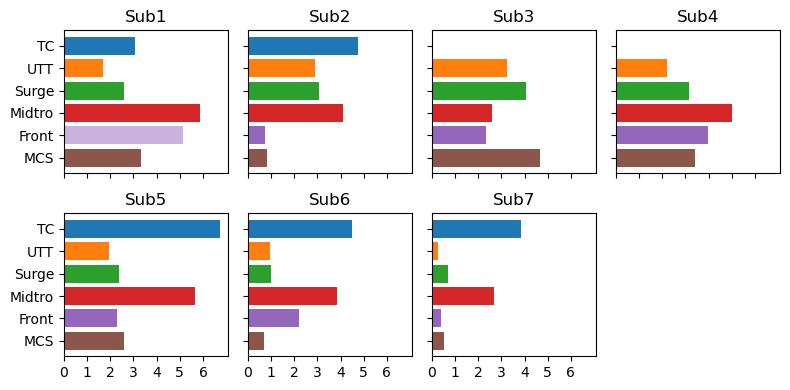

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(8, 4))
for sub_id in range(1, 8):
    ax = axes.flatten()[sub_id-1]
    [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    precip_list = [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip]
    CDF_single(sub_id, two_way_precip, precip_list, ax=ax)
    ax.set_yticks(ticks=np.arange(6, 0, -1))
    ax.set_yticklabels(names)
    ax.set_title('Sub'+str(sub_id))
    ax.set_xticks(ticks=np.arange(0, 7, 1))
    ax.set_xticklabels(np.arange(0, 7, 1))
fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.show()

In [11]:
def CDF_double(sub_id, two_way_precip, precip_list, ax):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    x = np.logspace(1, np.log(extreme*2), num=100, base=np.e)
    print('TOTAL: ', len(sub_precip))
    for i, precip in enumerate(two_way_precip):
        # print(names[i], len(precip))
        if len(precip) > 3:
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            if score_ga<score_gp:
                pdf = pdf = (gamma.cdf(x, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                threshold = 1- (gamma.cdf(extreme, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                dis = 'Gamma'
                # print(names[i], a1, scale1, threshold, len(precip))
            else:
                pdf = genpareto.cdf(x, a2, 1, scale2)
                dis = 'GenPareto'
                threshold = 1 - genpareto.cdf(extreme, a2, 1, scale2)
                # print(names[i], a2, scale2, threshold, len(precip))
            if len(precip)>10:
                alpha=1
            else:
                alpha=0.5
            ax.barh(y=15-i, width=threshold*100, alpha=alpha)  
        else:
            ax.barh(y=15-i, width=0, alpha=0) # take space for color arangement
                

TOTAL:  767
TOTAL:  761
TOTAL:  728
TOTAL:  1531
TOTAL:  2353
TOTAL:  2466
TOTAL:  3048


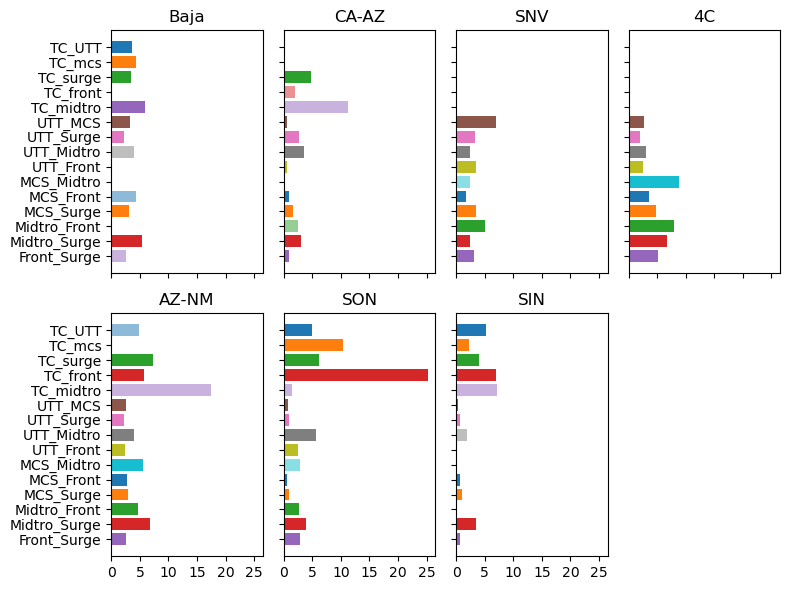

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(8, 6))
for sub_id in range(1, 8):
    ax = axes.flatten()[sub_id-1]
    [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    precip_list = [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip]
    CDF_double(sub_id, two_way_precip, precip_list, ax=ax)
    ax.set_yticks(ticks=np.arange(15, 0, -1))
    ax.set_yticklabels(two_way_names)
    ax.set_title(alias[sub_id])
    ax.set_xticks(ticks=np.arange(0, 26, 5))
fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.show()

In [13]:
def CDF_single_vertical(sub_id, two_way_precip, precip_list, ax):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    x = np.logspace(1, np.log(extreme*2), num=100, base=np.e)
    print('TOTAL: ', len(sub_precip))
    width = .2
    for i, precip in enumerate(precip_list):
        # print(names[i], len(precip))
        if len(precip) > 3:
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            if score_ga<score_gp:
                pdf = pdf = (gamma.cdf(x, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                threshold = 1- (gamma.cdf(extreme, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                dis = 'Gamma'
                # print(names[i], a1, scale1, threshold, len(precip))
            else:
                pdf = genpareto.cdf(x, a2, 1, scale2)
                dis = 'GenPareto'
                threshold = 1 - genpareto.cdf(extreme, a2, 1, scale2)
                # print(names[i], a2, scale2, threshold, len(precip))
            if len(precip)<10:
                fill=False
            else:
                fill=True
            if sub_id==7:
                ax.bar(x=(i)*(width+.03)+sub_id*2-2*width, height=threshold, width=width, label=names[i], color=colors[i], fill=fill, edgecolor=colors[i])  
            else:
                ax.bar(x=(i)*(width+.03)+sub_id*2-2*width, height=threshold, width=width, color=colors[i], fill=fill, edgecolor=colors[i])  
        else:
            ax.bar(x=(i)*width+sub_id*2-2*width, height=0, alpha=0, width=width) # take space for color arangement
                

TOTAL:  767
TOTAL:  761
TOTAL:  728
TOTAL:  1531
TOTAL:  2353
TOTAL:  2466
TOTAL:  3048


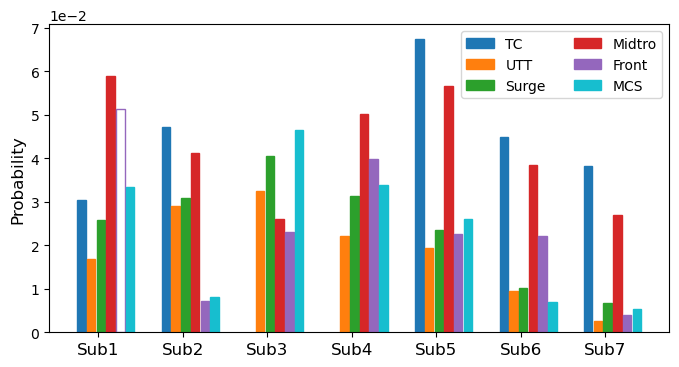

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
for sub_id in range(1, 8):
    [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    precip_list = [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip]
    CDF_single_vertical(sub_id, two_way_precip, precip_list, ax=ax)
plt.legend(ncol=2)
plt.xticks([2, 4, 6, 8, 10, 12, 14], labels=['Sub1', 'Sub2', 'Sub3', 'Sub4', 'Sub5', 'Sub6', 'Sub7'], fontsize=12)
plt.ylabel('Probability', fontsize=12)
from matplotlib.ticker import ScalarFormatter
yfmt = ScalarFormatter()
yfmt.set_powerlimits((-1,10))  # Or whatever your limits are . . .
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 10))
plt.savefig('CDF-single.png', dpi=120, bbox_inches='tight')
plt.show()

# Sub1 Examine

In [15]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=1)
print(len(tc_precip))

227


In [16]:
sub_precip = monsoon_precip.sel(sub_id=1)
sub_precip = sub_precip[sub_precip>1]
extreme = np.quantile(sub_precip, .95)
print(extreme)

21.363590636973544


In [17]:
print(len(midtro_precip))
count = 0
for precip in midtro_precip:
    if precip>extreme:
        count+=1
print(count)
print(count/len(midtro_precip))

27
5
0.18518518518518517


In [18]:
print(len(tc_precip))
count = 0
for precip in tc_precip:
    if precip>extreme:
        count+=1
print(count)
print(count/len(tc_precip))

227
26
0.1145374449339207


In [19]:
print(len(mcs_precip))
count = 0
for precip in mcs_precip:
    if precip>extreme:
        count+=1
print(count)
print(count/len(mcs_precip))

135
11
0.08148148148148149


In [20]:
print(len(surge_precip))
count = 0
for precip in surge_precip:
    if precip>extreme:
        count+=1
print(count)
print(count/len(surge_precip))

529
37
0.06994328922495274


In [21]:
print(len(front_precip))
count = 0
for precip in front_precip:
    if precip>extreme:
        count+=1
print(count)
print(count/len(front_precip))

9
1
0.1111111111111111


In [22]:
print(len(tutt_precip))
count = 0
for precip in tutt_precip:
    if precip>extreme:
        count+=1
print(count)
print(count/len(tutt_precip))

255
11
0.043137254901960784


In [23]:
def frequency(sub_id, precip_list):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    for i, p_list in enumerate(precip_list):
        count = 0
        for precip in p_list:
            if precip>extreme:
                count+=1
        print(names[i], count/len(p_list))
from scipy.stats import bootstrap
def stats(thredshold):
    def fraction(data):
        count = np.sum((data>thredshold))/data.shape[0]
        return count
    return fraction

def frequency_boots(sub_id, precip_list):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    for i, p_list in enumerate(precip_list):
        # print(type(p_list))
        p_data = np.array(p_list).flatten()
        res = bootstrap((p_data, ), stats(extreme), confidence_level=0.9, method='basic', vectorized=False)
        print(names[i], res.confidence_interval)
        '''frac = []
        for i in tqdm(range(200)):
            samples = np.random.choice(tc_precip, size=len(tc_precip), replace=True)
            (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_samples, None, x)
            if score_ga<score_gp:
                pdfs_tc.append(pdf1)
            else:
                pdfs_tc.append(pdf2)

        pdfs_tc = np.array(pdfs_tc)'''

In [24]:
CDF_single_print(sub_id=1, precip_list=[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip])

TOTAL:  767
TC 0.0305367998720929 736.2579507744986
UTT 0.01681138427508999 632.9853779036312
Surge 0.025758991278480803 1463.8061113884733
Midtro 0.05886349809423552 90.89015538636717
Front 0.051263025377466964 23.975843582263856
MCS 0.03338307852873246 379.70150944700225


In [25]:
frequency(sub_id=1, precip_list=[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip])

TC 0.1145374449339207
UTT 0.043137254901960784
Surge 0.06994328922495274
Midtro 0.18518518518518517
Front 0.1111111111111111
MCS 0.08148148148148149


In [26]:
frequency_boots(sub_id=1, precip_list=[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip])

TC ConfidenceInterval(low=0.07929515418502203, high=0.14977973568281938)
UTT ConfidenceInterval(low=0.0196078431372549, high=0.06274509803921569)
Surge ConfidenceInterval(low=0.05103969754253308, high=0.08695652173913043)
Midtro ConfidenceInterval(low=0.07407407407407407, high=0.2962962962962963)
Front ConfidenceInterval(low=-0.1111111111111111, high=0.2222222222222222)
MCS ConfidenceInterval(low=0.04444444444444445, high=0.11851851851851852)


In [27]:
def freq_single_vertical(sub_id, precip_list, ax):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    x = np.logspace(1, np.log(extreme*2), num=100, base=np.e)
    print('TOTAL: ', len(sub_precip), ' Sub: ', sub_id)
    width = .2
    for i, precip in enumerate(precip_list):
        frequency = 0
        for p_data in precip:
            if p_data>extreme:
                frequency+=1
        print(names[i], len(precip), frequency)
        frequency = frequency/len(precip)
        if frequency>0 and len(precip)>3:
            res = bootstrap((precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
            ci = res.confidence_interval
            left = np.max([ci[0], 0])
            right = ci[1]
            er1 = frequency-left
            er2 = right-frequency

            if sub_id==7:
                ax.bar(x=(i)*(width+.03)+sub_id*2-2*width, height=frequency*100, width=width, label=names[i], 
                       color=colors[i], yerr=np.array([er1, er2]).reshape(2, 1)*100)  
            else:
                ax.bar(x=(i)*(width+.03)+sub_id*2-2*width, height=frequency*100, width=width, color=colors[i], 
                       yerr=np.array([er1, er2]).reshape(2, 1)*100)
        else:
            ax.bar(x=(i)*(width+.03)+sub_id*2-2*width, height=0, width=width, color=colors[i], edgecolor=colors[i])

TOTAL:  767  Sub:  1
TC 227 26
UTT 255 11
Surge 529 37
Midtro 27 5
Front 9 1
MCS 135 11
TOTAL:  761  Sub:  2
TC 23 3
UTT 336 18
Surge 496 28
Midtro 42 5
Front 117 4
MCS 99 3
TOTAL:  728  Sub:  3
TC 1 1
UTT 335 14
Surge 465 31
Midtro 122 11
Front 200 8
MCS 22 0
TOTAL:  1531  Sub:  4
TC 2 1
UTT 786 35
Surge 814 48
Midtro 234 28
Front 548 39
MCS 98 13
TOTAL:  2353  Sub:  5
TC 29 7
UTT 1315 65
Surge 1287 81
Midtro 196 23
Front 799 55
MCS 481 41
TOTAL:  2466  Sub:  6
TC 89 24
UTT 1114 52
Surge 1519 99
Midtro 62 8
Front 379 19
MCS 623 40
TOTAL:  3048  Sub:  7
TC 178 28
UTT 1175 57
Surge 1050 74
Midtro 24 2
Front 262 13
MCS 959 54


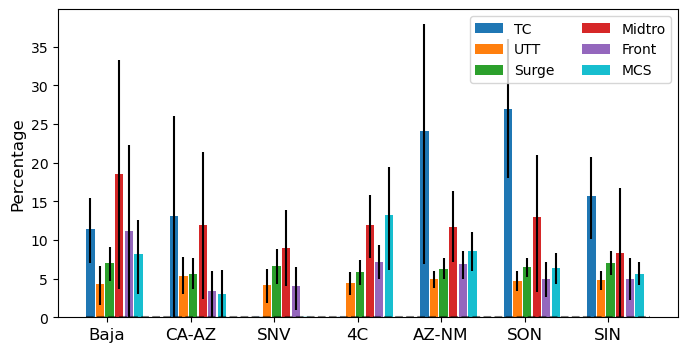

In [28]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
for sub_id in range(1, 8):
    [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    precip_list = [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip]
    freq_single_vertical(sub_id, precip_list, ax)
plt.legend(ncol=2)
plt.xticks([2, 4, 6, 8, 10, 12, 14], labels=['Baja', 'CA-AZ', 'SNV', '4C', 'AZ-NM', 'SON', 'SIN'], fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.hlines(y=0.05, xmin=1.5, xmax=15, color='black', linestyle='--', alpha=0.5)
from matplotlib.ticker import ScalarFormatter
yfmt = ScalarFormatter()
# yfmt.set_powerlimits((-1,10))  # Or whatever your limits are . . .
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 10))
plt.savefig('Freq-single.png', dpi=180, bbox_inches='tight')
plt.show()

In [29]:
def freq_double(sub_id, two_way_precip, ax):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    x = np.logspace(1, np.log(extreme*2), num=100, base=np.e)
    print('TOTAL: ', len(sub_precip))
    for i, precip in enumerate(two_way_precip):
        if len(precip)>0:
            frequency = 0
            for p_data in precip:
                if p_data>extreme:
                    frequency+=1
            # print(names[i], len(precip), frequency)
            frequency = frequency/len(precip)
            if frequency>0 and len(precip)>3:
                res = bootstrap((precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
                ci = res.confidence_interval
                left = np.max([ci[0], 0])
                right = ci[1]
                er1 = frequency-left
                er2 = right-frequency
                ax.barh(y=15-i, width=frequency*100, xerr=np.array([er1, er2]).reshape(2, 1)*100)
                # print('YES')
            else:
                ax.barh(y=15-i, width=0, alpha=0) # take space for color arangement
                
        else:
            ax.barh(y=15-i, width=0, alpha=0) # take space for color arangement
                

TOTAL:  767
TOTAL:  761
TOTAL:  728
TOTAL:  1531
TOTAL:  2353
TOTAL:  2466
TOTAL:  3048


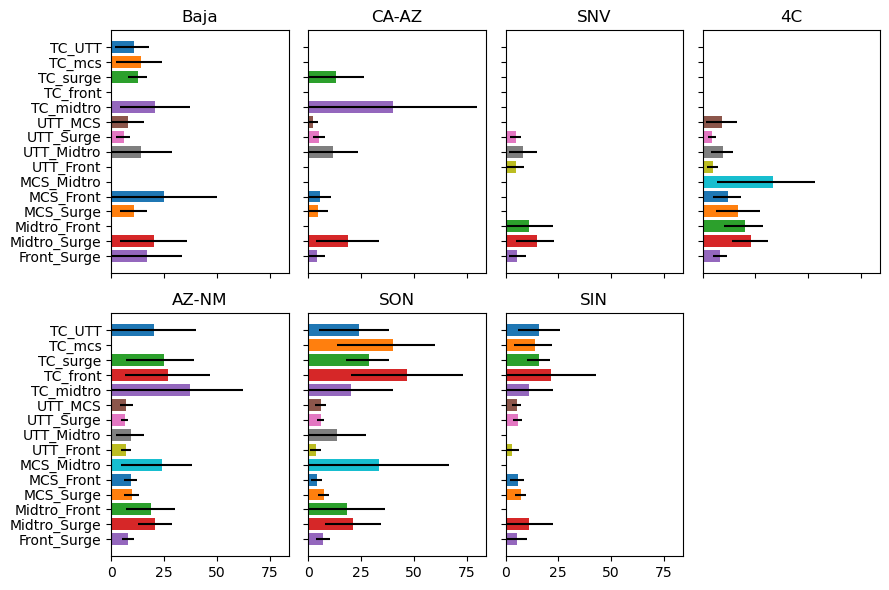

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(9, 6))
for sub_id in range(1, 8):
    ax = axes.flatten()[sub_id-1]
    [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    precip_list = [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip]
    freq_double(sub_id, two_way_precip, ax=ax)
    ax.set_yticks(ticks=np.arange(15, 0, -1))
    ax.set_yticklabels(two_way_names)
    ax.set_title(alias[sub_id])
    ax.set_xticks(ticks=np.linspace(0, 75, 4))
fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.savefig('Freq-double.png', dpi=120, bbox_inches='tight')
plt.show()

In [31]:
np.linspace(0, 0.75, 4)

array([0.  , 0.25, 0.5 , 0.75])

In [32]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=1)

In [33]:
sub_precip = monsoon_precip.sel(sub_id=1)
sub_precip = sub_precip[sub_precip>1]
extreme = np.quantile(sub_precip, .95)
print(extreme)

21.363590636973544


In [34]:
count=0
for p in tutt_precip:
    if p>extreme:
        count+=1
print(count/len(tutt_precip))
res = bootstrap((tutt_precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

0.043137254901960784
ConfidenceInterval(low=0.01568627450980392, high=0.06666666666666667)


In [35]:
utt_surge=two_way_precip[6]
print(two_way_names[6])
count=0
for p in utt_surge:
    if p>extreme:
        count+=1
print(count/len(utt_surge))
res = bootstrap((utt_surge, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

UTT_Surge
0.05847953216374269
ConfidenceInterval(low=0.023391812865497075, high=0.0935672514619883)


In [36]:
tc_utt=two_way_precip[0]
print(len(tc_utt))
count=0
print(two_way_names[0])
for p in tc_utt:
    if p>extreme:
        count+=1
print(count/len(tc_utt))
res = bootstrap((tc_utt, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

56
TC_UTT
0.10714285714285714
ConfidenceInterval(low=0.01785714285714285, high=0.17857142857142855)


In [37]:
count=0
for p in tc_precip:
    if p>extreme:
        count+=1
print(count/len(tc_precip))
res = bootstrap((tc_precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

0.1145374449339207
ConfidenceInterval(low=0.07048458149779735, high=0.15418502202643172)


# 5-degree utt

In [38]:
def get_precip_utt_5(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT-5degree.npy')
    # tc_sub = np.load(str(sub_id)+'_all_TC.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    # two-way
    tc_tutt_precip = []
    tc_mcs_precip = []
    tc_surge_precip = []
    tc_front_precip = []
    tc_midtro_precip = []
    tutt_mcs_precip = []
    tutt_surge_precip = []
    tutt_midtro_precip = []
    tutt_front_precip = []
    mcs_midtro_precip = []
    mcs_front_precip = []
    mcs_surge_precip = []
    midtro_front_precip = []
    midtro_surge_precip = []
    front_surge_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        # 2-way
        if midtro_sub[i]>0 and front_sub[i]>0:
            midtro_front_precip.append(sub_precip[i])
        if midtro_sub[i]>0 and surge_sub[i]>0:
            midtro_surge_precip.append(sub_precip[i])
        if surge_sub[i]>0 and front_sub[i]>0:
            front_surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and front_sub[i]>0:
            mcs_front_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and midtro_sub[i]>0:
            mcs_midtro_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and surge_sub[i]>0:
            mcs_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and tutt_sub[i]>0:
            tc_tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0 and front_sub[i]>0:
            tc_front_precip.append(sub_precip[i])
        if tc_sub[i]>0 and surge_sub[i]>0:
            tc_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and midtro_sub[i]>0:
            tc_midtro_precip.append(sub_precip[i])
        if tc_sub[i]>0 and mcs_sub[i]>0:
            tc_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and front_sub[i]>0:
            tutt_front_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and surge_sub[i]>0:
            tutt_surge_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and midtro_sub[i]>0:
            tutt_midtro_precip.append(sub_precip[i])
    two_way_precip = [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
                      tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
                      mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
                      midtro_front_precip, midtro_surge_precip,
                      front_surge_precip,]
    return [tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
            two_way_precip

In [39]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip_utt_5(sub_id=1)

In [40]:
tc_utt=two_way_precip[0]
print(len(tc_utt))
count=0
print(two_way_names[0])
for p in tc_utt:
    if p>extreme:
        count+=1
print(count/len(tc_utt))
res = bootstrap((tc_utt, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

15
TC_UTT
0.0
ConfidenceInterval(low=0.0, high=0.0)


In [41]:
count=0
for p in tc_precip:
    if p>extreme:
        count+=1
print(count/len(tc_precip))
res = bootstrap((tc_precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

0.1145374449339207
ConfidenceInterval(low=0.07048458149779735, high=0.15418502202643172)


# Front-Midtro-GenPareto

In [42]:
sub_id = 5
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
extreme_5 = np.quantile(sub_precip, .95)
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')
x_5 = np.logspace(1, np.log(extreme_5*2), num=100, base=np.e)
front_w_midtro_precip = []
front_wo_midtro_precip = []
front_precip = []
for i in range(sub_precip.shape[0]):
    if front_sub[i]>0 and midtro_sub[i]>0:
        front_w_midtro_precip.append(sub_precip[i])
    elif front_sub[i]>0 and midtro_sub[i]<=0:
        front_wo_midtro_precip.append(sub_precip[i])
    if front_sub[i]>0:
        front_precip.append(sub_precip[i])
print(len(front_w_midtro_precip))
print(len(front_wo_midtro_precip))
front_w_midtro_precip_5 = front_w_midtro_precip
front_wo_midtro_precip_5 = front_wo_midtro_precip
front_precip_5 = front_precip

43
756


In [43]:
sub_id = 4
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
extreme_4 = np.quantile(sub_precip, .95)
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')
x_4 = np.logspace(1, np.log(extreme_4*2), num=100, base=np.e)
front_w_midtro_precip = []
front_wo_midtro_precip = []
front_precip = []
for i in range(sub_precip.shape[0]):
    if front_sub[i]>0 and midtro_sub[i]>0:
        front_w_midtro_precip.append(sub_precip[i])
    elif front_sub[i]>0 and midtro_sub[i]<=0:
        front_wo_midtro_precip.append(sub_precip[i])
    if front_sub[i]>0:
        front_precip.append(sub_precip[i])
print(len(front_w_midtro_precip))
print(len(front_wo_midtro_precip))
front_w_midtro_precip_4 = front_w_midtro_precip
front_wo_midtro_precip_4 = front_wo_midtro_precip
front_precip_4 = front_precip

70
478


In [44]:
from utils import fit_gamma_genpareto
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_w_midtro_precip_4, None, x_4)
pdf_front_w_midtro_4 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_wo_midtro_precip_4, None, x_4)
pdf_front_wo_midtro_4 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_precip_4, None, x_4)
pdf_front_4 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_w_midtro_precip_5, None, x_5)
pdf_front_w_midtro_5 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_wo_midtro_precip_5, None, x_5)
pdf_front_wo_midtro_5 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_precip_5, None, x_5)
pdf_front_5 = pdf2

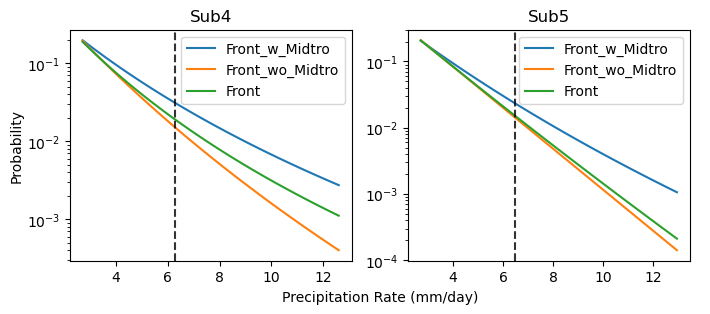

In [45]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
ax.plot(x_4, pdf_front_w_midtro_4, label='Front_w_Midtro')
ax.plot(x_4, pdf_front_wo_midtro_4, label='Front_wo_Midtro')
ax.plot(x_4, pdf_front_4, label='Front')
ax.axvline(extreme_4, color='black', alpha=0.8, linestyle='--')
ax.legend()
ax.set_title('Sub4')
ax.set_yscale('log')
ax = fig.add_subplot(122)
ax.plot(x_5, pdf_front_w_midtro_5, label='Front_w_Midtro')
ax.plot(x_5, pdf_front_wo_midtro_5, label='Front_wo_Midtro')
ax.plot(x_5, pdf_front_5, label='Front')
ax.axvline(extreme_5, color='black', alpha=0.8, linestyle='--')
ax.legend()
ax.set_title('Sub5')
ax.set_yscale('log')
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Precipitation Rate (mm/day)")
plt.ylabel("Probability", labelpad=10)
# plt.savefig('Sub4Sub5FrontMidtroGP.png', dpi=120, bbox_inches='tight')
plt.show()

# TC-utt

In [46]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip_utt_5(sub_id=1)
tc_precip_1 = tc_precip
tc_utt_1_5d = two_way_precip[0]
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=1)
tc_utt_1_10d = two_way_precip[0]
sub_id = 1
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
extreme_1 = np.quantile(sub_precip, .95)
x_1 = np.logspace(1, np.log(extreme_1*2), num=100, base=np.e)

In [47]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip, None, x_1)
pdf_tc_1 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_utt_1_5d, None, x_1)
pdf_tc_utt_1_5d = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_utt_1_10d, None, x_1)
pdf_tc_utt_1_10d = pdf2

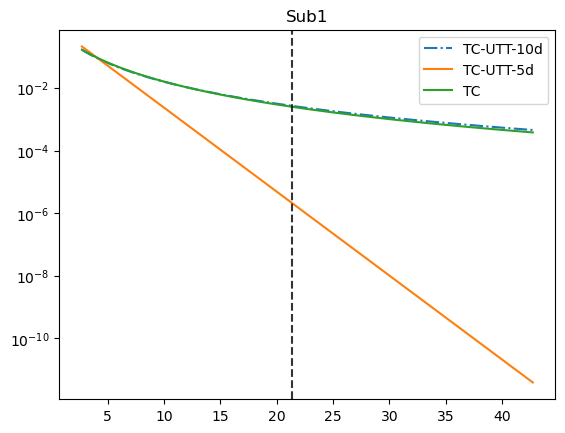

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_1, pdf_tc_utt_1_10d, label='TC-UTT-10d', linestyle='-.')
ax.plot(x_1, pdf_tc_utt_1_5d, label='TC-UTT-5d')
ax.plot(x_1, pdf_tc_1, label='TC')
ax.axvline(extreme_1, color='black', alpha=0.8, linestyle='--')
ax.legend()
ax.set_title('Sub1')
ax.set_yscale('log')
plt.show()

# TC-Surge

In [49]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip_utt_5(sub_id=1)
tc_surge_1 = two_way_precip[2]

In [50]:
sub_id = 1
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
extreme_1 = np.quantile(sub_precip, .95)
x_1 = np.logspace(1, np.log(extreme_1*2), num=100, base=np.e)

(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_surge_1, None, x_1)
pdf_tc_surge_1 = pdf2

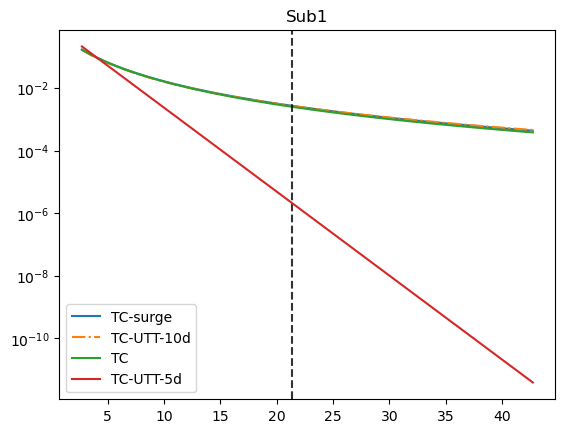

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_1, pdf_tc_surge_1, label='TC-surge')
ax.plot(x_1, pdf_tc_utt_1_10d, label='TC-UTT-10d', linestyle='-.')
ax.plot(x_1, pdf_tc_1, label='TC')
ax.axvline(extreme_1, color='black', alpha=0.8, linestyle='--')
ax.plot(x_1, pdf_tc_utt_1_5d, label='TC-UTT-5d')
ax.legend()
ax.set_title('Sub1')
ax.set_yscale('log')
plt.show()

In [52]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip_utt_5(sub_id=7)
tc_surge_7 = two_way_precip[2]
tc_precip_7 = tc_precip
sub_id = 7
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
extreme_7 = np.quantile(sub_precip, .95)
x_7 = np.logspace(1, np.log(extreme_7*2), num=100, base=np.e)

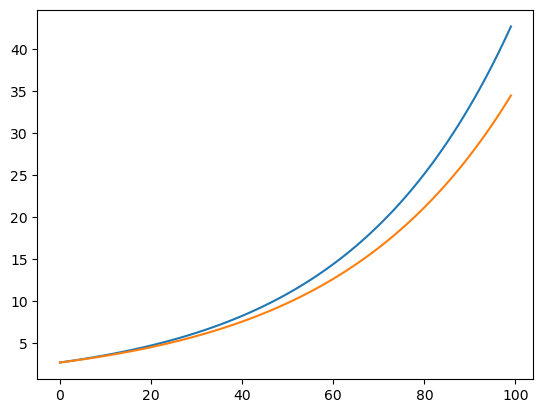

In [53]:
plt.plot(x_1)
plt.plot(x_7)

In [54]:
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip_7, None, x_7)
pdf_tc_7 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_surge_7, None, x_7)
pdf_tc_surge_7 = pdf2

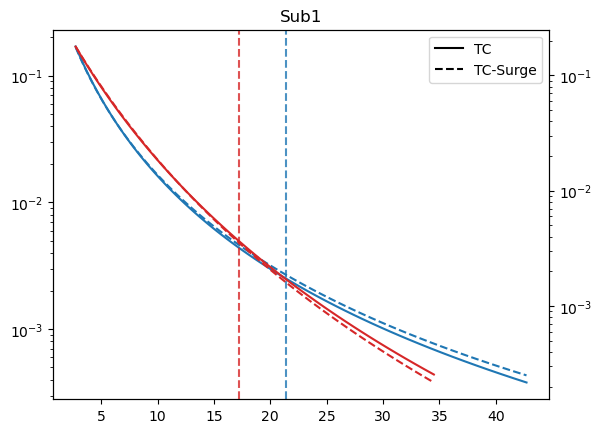

In [55]:
from matplotlib.lines import Line2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_1, pdf_tc_1, label='TC-Sub1', color='tab:blue')
ax.plot(x_1, pdf_tc_surge_1, label='TC-Surge-Sub1', color='tab:blue', linestyle='--')
ax.axvline(extreme_1, alpha=0.8, linestyle='--', color='tab:blue')
ax2 = ax.twinx()
ax2.plot(x_7, pdf_tc_7, label='TC-Sub7', color='tab:red')
ax2.plot(x_7, pdf_tc_surge_7, label='TC-Surge-Sub7', color='tab:red', linestyle='--')
ax2.axvline(extreme_7, alpha=0.8, linestyle='--', color='tab:red')
ax2.set_yscale('log')
ax.set_title('Sub1')
ax.set_yscale('log')
line1 = Line2D([0,1],[0,1],linestyle='-', color='k')
line2 = Line2D([0,1],[0,1],linestyle='--', color='k')
ax.legend([line1, line2],['TC', 'TC-Surge'])
plt.show()

In [56]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip_utt_5(sub_id=7)
tc_precip_7 = tc_precip
utt_precip_7_5d = tutt_precip
tc_utt_7_5d = two_way_precip[0]
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=7)
tc_utt_7_10d = two_way_precip[0]
utt_precip_7_10d = tutt_precip
sub_id = 7
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
extreme_7 = np.quantile(sub_precip, .95)
x_7 = np.logspace(1, np.log(extreme_7*2), num=100, base=np.e)
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip_7, None, x_7)
pdf_tc_7 = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_utt_7_5d, None, x_7)
pdf_tc_utt_7_5d = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_utt_7_10d, None, x_7)
pdf_tc_utt_7_10d = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(utt_precip_7_5d, None, x_7)
pdf_utt_7_5d = pdf2
(a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(utt_precip_7_10d, None, x_7)
pdf_utt_7_10d = pdf2

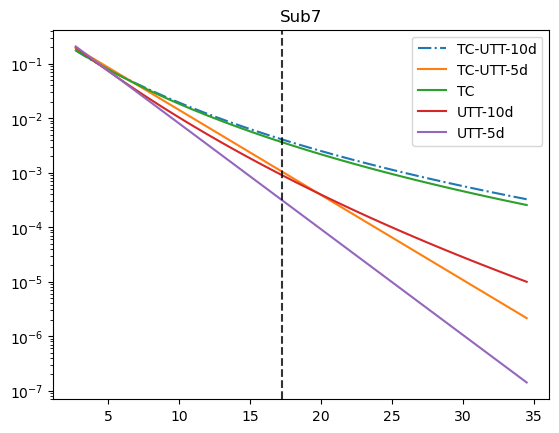

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_7, pdf_tc_utt_7_10d, label='TC-UTT-10d', linestyle='-.')
ax.plot(x_7, pdf_tc_utt_7_5d, label='TC-UTT-5d')
ax.plot(x_7, pdf_tc_7, label='TC')
ax.plot(x_7, pdf_utt_7_10d, label='UTT-10d')
ax.plot(x_7, pdf_utt_7_5d, label='UTT-5d')
ax.axvline(extreme_7, color='black', alpha=0.8, linestyle='--')
ax.legend()
ax.set_title('Sub7')
ax.set_yscale('log')
plt.show()

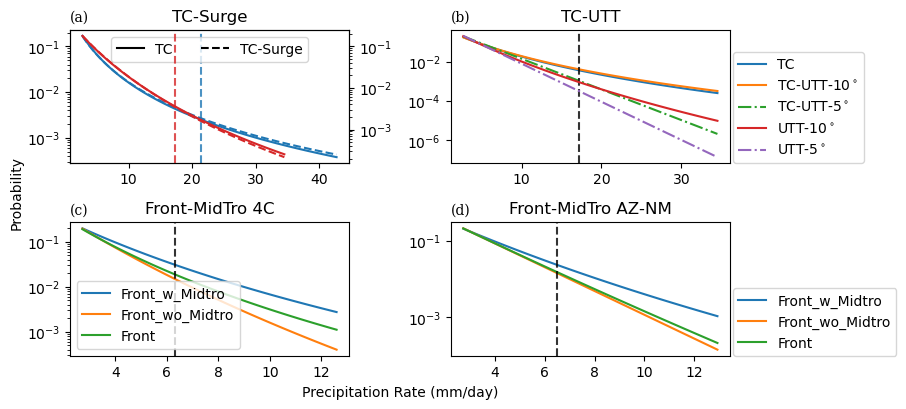

In [58]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(221)
ax.plot(x_1, pdf_tc_1, label='TC', color='tab:blue')
ax.plot(x_1, pdf_tc_surge_1, label='TC-surge', color='tab:blue', linestyle='--')
ax.axvline(extreme_1, color='tab:blue', alpha=0.8, linestyle='--')
ax.set_yscale('log')
ax.set_title('TC-Surge')
ax.set_title('(a)', fontfamily='serif', loc='left', fontsize='medium')
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.plot(x_7, pdf_tc_7, label='TC-Sub7', color='tab:red')
ax2.plot(x_7, pdf_tc_surge_7, label='TC-Surge-Sub7', color='tab:red', linestyle='--')
ax2.axvline(extreme_7, alpha=0.8, linestyle='--', color='tab:red')
ax.legend([line1, line2],['TC', 'TC-Surge'], loc='upper center', ncol=2)
ax = fig.add_subplot(222)
ax.plot(x_7, pdf_tc_7, label='TC')
ax.plot(x_7, pdf_tc_utt_7_10d, label='TC-UTT-10$^\circ$')
ax.plot(x_7, pdf_tc_utt_7_5d, label='TC-UTT-5$^\circ$', linestyle='-.')
ax.axvline(extreme_7, color='black', alpha=0.8, linestyle='--')
ax.plot(x_7, pdf_utt_7_10d, label='UTT-10$^\circ$')
ax.plot(x_7, pdf_utt_7_5d, label='UTT-5$^\circ$', linestyle='-.')
ax.set_yscale('log')
ax.set_title('TC-UTT')
ax.set_title('(b)', fontfamily='serif', loc='left', fontsize='medium')
ax.legend(loc=(1.01, 0), ncol=1)
ax = fig.add_subplot(223)
ax.plot(x_4, pdf_front_w_midtro_4, label='Front_w_Midtro')
ax.plot(x_4, pdf_front_wo_midtro_4, label='Front_wo_Midtro')
ax.plot(x_4, pdf_front_4, label='Front')
ax.axvline(extreme_4, color='black', alpha=0.8, linestyle='--')
ax.legend()
ax.set_title('Front-MidTro 4C')
ax.set_yscale('log')
ax.set_title('(c)', fontfamily='serif', loc='left', fontsize='medium')
ax = fig.add_subplot(224)
ax.plot(x_5, pdf_front_w_midtro_5, label='Front_w_Midtro')
ax.plot(x_5, pdf_front_wo_midtro_5, label='Front_wo_Midtro')
ax.plot(x_5, pdf_front_5, label='Front')
ax.axvline(extreme_5, color='black', alpha=0.8, linestyle='--')
ax.legend(loc=(1.01, 0))
ax.set_title('Front-MidTro AZ-NM')
ax.set_yscale('log')
ax.set_title('(d)', fontfamily='serif', loc='left', fontsize='medium')
plt.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Precipitation Rate (mm/day)")
plt.ylabel("Probability", labelpad=10)
plt.savefig('GP-Interact.png', dpi=120, bbox_inches='tight')

# Sub6 TC midtro

In [59]:
[tc_precip, tutt_precip, surge_precip, midtro_precip, front_precip, mcs_precip], \
    two_way_precip = get_precip(sub_id=6)
sub_precip = monsoon_precip.sel(sub_id=6)
sub_precip = sub_precip[sub_precip>1]
extreme = np.quantile(sub_precip, .95)
print(extreme)

10.647874758983226


In [60]:
two_way_names

['TC_UTT',
 'TC_mcs',
 'TC_surge',
 'TC_front',
 'TC_midtro',
 'UTT_MCS',
 'UTT_Surge',
 'UTT_Midtro',
 'UTT_Front',
 'MCS_Midtro',
 'MCS_Front',
 'MCS_Surge',
 'Midtro_Front',
 'Midtro_Surge',
 'Front_Surge']

In [61]:
TC_midtro_precip = two_way_precip[4]
count=0
for p in TC_midtro_precip:
    if p>extreme:
        count+=1
print(count/len(TC_midtro_precip))
res = bootstrap((TC_midtro_precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

0.2
ConfidenceInterval(low=-0.09999999999999998, high=0.4)


In [62]:
len(TC_midtro_precip)

10

In [63]:
count=0
for p in tc_precip:
    if p>extreme:
        count+=1
print(count/len(tc_precip))
res = bootstrap((tc_precip, ), stats(extreme), confidence_level=0.95, method='basic', vectorized=False)
print(res.confidence_interval)

0.2696629213483146
ConfidenceInterval(low=0.1797752808988764, high=0.3595505617977528)
